### Titanic Dataset: Kaggle
#### Goal: Predict which passenger survived

In [105]:
# import packages 
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
sns.set(style='white')
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
rcParams['figure.figsize'] = 8,5

In [106]:
# Reading data set 

train_data = pd.read_csv('train.csv')


In [199]:
test_data = pd.read_csv('test.csv')

In [107]:
print(train_data.shape)
print(list(train_data.columns))

(891, 12)
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [108]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [109]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [110]:
train_data.drop(['Ticket', 'PassengerId'], axis=1, inplace=True)

In [111]:
gender_mapper = {'male': 0, 'female': 1}
train_data['Sex'].replace(gender_mapper, inplace=True)

In [112]:
train_data['Title'] = train_data['Name'].apply(lambda x: x.split(',')[1].strip().split(' ')[0])
train_data['Title'] = [0 if x in ['Mr.', 'Mrs.', 'Miss.'] else 1 for x in train_data['Title']]
train_data = train_data.rename(columns={'Title': 'Title_Unusual'})
train_data.drop('Name', axis=1, inplace=True)

In [113]:
train_data['Cabin_Known'] = [0 if str(x) == 'nan' else 1 for x in train_data['Cabin']]
train_data.drop('Cabin', axis=1, inplace=True)

In [114]:
emb_dummies = pd.get_dummies(train_data['Embarked'], drop_first=True, prefix='Embarked')
train_data = pd.concat([train_data, emb_dummies], axis=1)
train_data.drop('Embarked', axis=1, inplace=True)

In [115]:
train_data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Unusual,Cabin_Known,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,0,0,1
1,1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,1,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,0,1
5,0,3,0,NaN,0,0,8.4583,0,0,1,0
6,0,1,0,54.0,0,0,51.8625,0,1,0,1
7,0,3,0,2.0,3,1,21.0750,1,0,0,1
8,1,3,1,27.0,0,2,11.1333,0,0,0,1
9,1,2,1,14.0,1,0,30.0708,0,0,0,0


#### Data Explorations

In [116]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

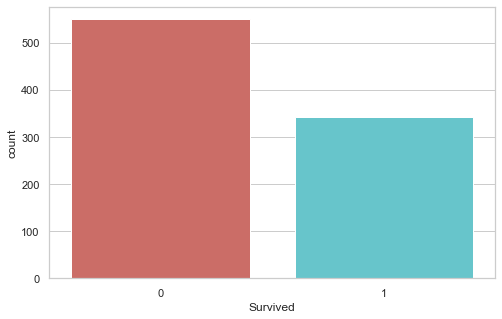

In [117]:
sns.countplot(x='Survived', data=train_data, palette='hls')
plt.show()

In [118]:
count_survived = len(train_data.loc[train_data['Survived']==1, ['Survived']])
count_died = len(train_data.loc[train_data['Survived']==0, ['Survived']])
percent_survived = count_survived / (count_survived + count_died)
percent_died = count_died / (count_survived + count_died)

print("Percentage survived: {}".format(percent_survived*100))
print("Percentage Died: {}".format(percent_died*100))

Percentage survived: 38.38383838383838
Percentage Died: 61.61616161616161


#### Percentage of people who survived and died and imbalanced in the training data set

In [119]:
train_data.groupby('Survived').mean()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Unusual,Cabin_Known,Embarked_Q,Embarked_S
Survived,,,,,,,,,,
0,2.531876,0.147541,30.626179,0.553734,0.329690,22.117887,0.058288,0.123862,0.085610,0.777778
1,1.950292,0.681287,28.343690,0.473684,0.464912,48.395408,0.102339,0.397661,0.087719,0.634503


In [120]:
train_data.groupby('Sex').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,Title_Unusual,Cabin_Known,Embarked_Q,Embarked_S
Sex,,,,,,,,,,
0,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893,0.103986,0.185442,0.071057,0.764298
1,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818,0.022293,0.308917,0.114650,0.646497


In [121]:
train_data['Sex'].value_counts()

0    577
1    314
Name: Sex, dtype: int64

In [122]:
train_data['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [123]:
train_data['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

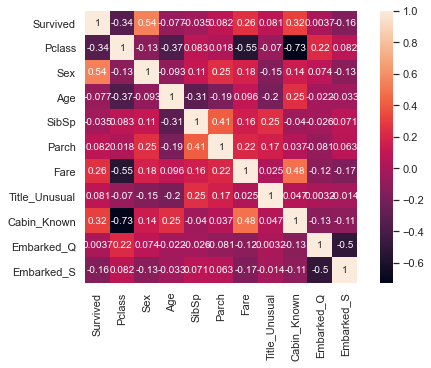

In [124]:
sns.heatmap(train_data.corr(), annot=True, square=True)

- Pclass and Fare seem to be highly correlated, which makes sense since higher fare would most likely mean lower class
- Pclass and Cabin are also highly correlated
- Age and Pclass also are correlated. 
- Siblings and Parents are highly correlated variables as well. 

In [125]:
total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Age,177,0.198653
Embarked_S,0,0.000000
Embarked_Q,0,0.000000
Cabin_Known,0,0.000000
Title_Unusual,0,0.000000
Fare,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Pclass,0,0.000000


In [126]:
from impyute.imputation.cs import mice

X = train_data.drop('Survived', axis=1)

imputed = mice(X.values)
train_data['Age'] = imputed[:,2]

In [127]:
train_data['Age'] = train_data['Age'].clip(lower=0)

In [128]:
train_data['Age'].describe()

count    891.000000
mean      29.565489
std       13.573825
min        0.000000
25%       21.000000
50%       28.606362
75%       36.537102
max       80.000000
Name: Age, dtype: float64

#### Visualizing data 

Text(0, 0.5, 'Survived')

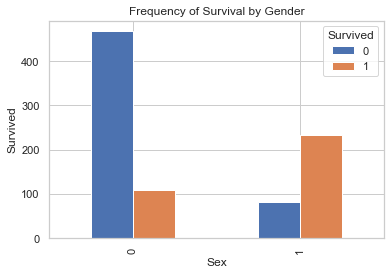

In [129]:
%matplotlib inline 
pd.crosstab(train_data.Sex, train_data.Survived).plot(kind='bar')
plt.title('Frequency of Survival by Gender')
plt.xlabel('Sex')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

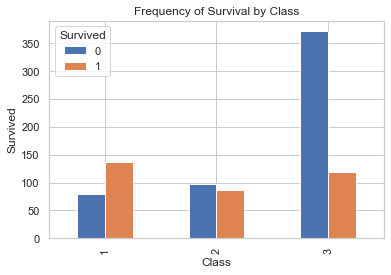

In [130]:
pd.crosstab(train_data.Pclass, train_data.Survived).plot(kind='bar')
plt.title('Frequency of Survival by Class')
plt.xlabel('Class')
plt.ylabel('Survived')

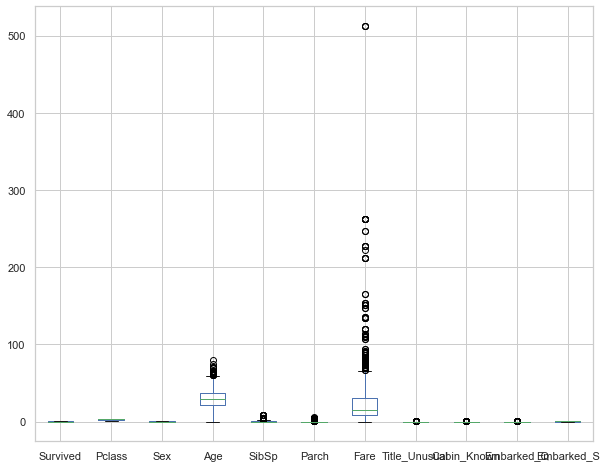

In [131]:
# Outlier detection
train_data.plot(kind='box', figsize=(10,8))

In [132]:
cols = ['Fare', 'Age', 'SibSp', 'Parch']
train_data[cols] = train_data[cols].clip(lower=train_data[cols].quantile(0.15), upper = train_data[cols].quantile(0.85), axis=1)

train_data.drop(columns=['SibSp', 'Pclass'], inplace=True)

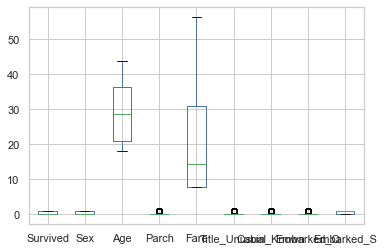

In [133]:
train_data.plot(kind='box')

In [134]:
# Create Dummy Variables 
cat_variables = ['Sex']
for var in cat_variables:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(train_data[var], prefix=var)
    data1=train_data.join(cat_list)
    train_data=data1
    
cat_variables = ['Sex']
data_vars = train_data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_variables]

In [135]:
data_final = train_data[to_keep]
data_final.columns.values

array(['Survived', 'Age', 'Parch', 'Fare', 'Title_Unusual', 'Cabin_Known',
       'Embarked_Q', 'Embarked_S', 'Sex_0', 'Sex_1'], dtype=object)

In [136]:
x = data_final.loc[:, data_final.columns != 'Survived']
y = data_final.loc[:, data_final.columns == 'Survived']

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.3, random_state=0)
columns = X_train.columns 

os_data_X, os_data_Y = os.fit_sample(X_train, Y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_Y= pd.DataFrame(data=os_data_Y,columns=['Survived'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of people died in oversampled data",len(os_data_Y[os_data_Y['Survived']==0]))
print("Number of people survived",len(os_data_Y[os_data_Y['Survived']==1]))
print("Proportion of people died in oversampled data is ",len(os_data_Y[os_data_Y['Survived']==0])/len(os_data_X))
print("Proportion of people who survived in oversampled data is ",len(os_data_Y[os_data_Y['Survived']==1])/len(os_data_X))

length of oversampled data is  762
Number of people died in oversampled data 381
Number of people survived 381
Proportion of people died in oversampled data is  0.5
Proportion of people who survived in oversampled data is  0.5


In [137]:
# Build the model 
data_final_vars = data_final.columns.values.tolist()
y = ['Survived']
x = [i for i in data_final_vars if i not in y]

from sklearn.feature_selection import RFE 
from sklearn.linear_model import LogisticRegression 

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_Y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1]


C:\Users\priya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\priya\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [138]:
x = os_data_X
y = os_data_Y['Survived']

In [139]:
import statsmodels.api as sm 
logit_model = sm.Logit(y,x)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.463877
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.331     
Dependent Variable: Survived         AIC:              724.9489  
Date:               2021-01-03 10:13 BIC:              766.6724  
No. Observations:   762              Log-Likelihood:   -353.47   
Df Model:           8                LL-Null:          -528.18   
Df Residuals:       753              LLR p-value:      1.2116e-70
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Age                0.0422   0.0099  4.2513 0.0000  0.0228  0.0617
Parch             -0.4671   0.2497 -1.8709 0.0614 -0.9564  0.0222


In [140]:
cols = ['Age', 'Fare', 'Title_Unusual', 'Cabin_Known', 'Embarked_S', 'Sex_0']

X = os_data_X[cols]
Y = os_data_Y['Survived']

In [141]:
logit_model = sm.Logit(Y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.468229
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.324     
Dependent Variable: Survived         AIC:              725.5809  
Date:               2021-01-03 10:16 BIC:              753.3966  
No. Observations:   762              Log-Likelihood:   -356.79   
Df Model:           5                LL-Null:          -528.18   
Df Residuals:       756              LLR p-value:      6.2863e-72
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Age               0.0395   0.0076   5.2206 0.0000  0.0247  0.0543
Fare              0.0141   0.0063   2.2428 0.0249  0.0018  0.0265


In [142]:
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics 

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression()

In [143]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [144]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, y_pred)
print(confusion_matrix)

[[101  18]
 [ 23  87]]


In [145]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       119
           1       0.83      0.79      0.81       110

    accuracy                           0.82       229
   macro avg       0.82      0.82      0.82       229
weighted avg       0.82      0.82      0.82       229



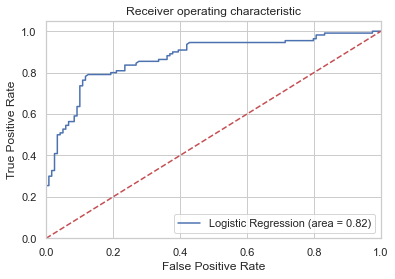

In [147]:
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [200]:
# Work with the test.csv data to fit the model on the dataset to predict the values. 

test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [201]:
test_data.shape

(418, 11)

In [202]:
test_data.drop(['Ticket'], axis=1, inplace=True)
test_data = test_data.set_index('PassengerId')

In [203]:
gender_mapper = {'male': 0, 'female': 1}
test_data['Sex'].replace(gender_mapper, inplace=True)

test_data['Title'] = test_data['Name'].apply(lambda x: x.split(',')[1].strip().split(' ')[0])
test_data['Title'] = [0 if x in ['Mr.', 'Miss.', 'Mrs.'] else 1 for x in test_data['Title']]
test_data = test_data.rename(columns={'Title': 'Title_Unusual'})
test_data.drop('Name', axis=1, inplace=True)

test_data['Cabin_Known'] = [0 if str(x) == 'nan' else 1 for x in test_data['Cabin']]
test_data.drop('Cabin', axis=1, inplace=True)

emb_dummies = pd.get_dummies(test_data['Embarked'], drop_first=True, prefix='Embarked')
test_data = pd.concat([test_data, emb_dummies], axis=1)
test_data.drop('Embarked', axis=1, inplace=True)

In [204]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Unusual,Cabin_Known,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
892,3,0,34.5,0,0,7.8292,0,0,1,0
893,3,1,47.0,1,0,7.0000,0,0,0,1
894,2,0,62.0,0,0,9.6875,0,0,1,0
895,3,0,27.0,0,0,8.6625,0,0,0,1
896,3,1,22.0,1,1,12.2875,0,0,0,1


In [205]:
total = test_data.isnull().sum().sort_values(ascending=False)
percent = (test_data.isnull().sum()/test_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Age,86,0.205742
Fare,1,0.002392
Embarked_S,0,0.000000
Embarked_Q,0,0.000000
Cabin_Known,0,0.000000
Title_Unusual,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Pclass,0,0.000000


In [206]:
X = test_data.copy()

imputed = mice(X.values)
test_data['Age'] = imputed[:,2]

In [207]:
test_data['Age'] = test_data['Age'].clip(lower=0)

In [208]:
test_data['Age'].describe()

count    418.000000
mean      29.564341
std       13.022990
min        0.170000
25%       22.000000
50%       26.464383
75%       36.000000
max       76.000000
Name: Age, dtype: float64

In [211]:
test_data['Fare'] = test_data['Fare'].fillna(0)

In [212]:
total = test_data.isnull().sum().sort_values(ascending=False)
percent = (test_data.isnull().sum()/test_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Embarked_S,0,0.0
Embarked_Q,0,0.0
Cabin_Known,0,0.0
Title_Unusual,0,0.0
Fare,0,0.0
Parch,0,0.0
SibSp,0,0.0
Age,0,0.0
Sex,0,0.0
Pclass,0,0.0


In [213]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Unusual,Cabin_Known,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
892,3,0,34.5,0,0,7.8292,0,0,1,0
893,3,1,47.0,1,0,7.0000,0,0,0,1
894,2,0,62.0,0,0,9.6875,0,0,1,0
895,3,0,27.0,0,0,8.6625,0,0,0,1
896,3,1,22.0,1,1,12.2875,0,0,0,1


In [214]:
# Create Dummy Variables 
cat_variables = ['Sex']
for var in cat_variables:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(test_data[var], prefix=var)
    data1=test_data.join(cat_list)
    test_data=data1
    
cat_variables = ['Sex']
data_vars = test_data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_variables]

data_final = test_data[to_keep]
data_final.columns.values

array(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Title_Unusual',
       'Cabin_Known', 'Embarked_Q', 'Embarked_S', 'Sex_0', 'Sex_1'],
      dtype=object)

In [215]:
data_final.drop(columns = ['Pclass', 'SibSp', 'Parch', 'Embarked_Q', 'Sex_1'], axis=1, inplace=True)

C:\Users\priya\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [216]:
y_pred = logreg.predict(data_final)

In [217]:
passenger_list = data_final.index.values

In [218]:
final_df = pd.DataFrame(columns=['PassengerId', 'Survived'])

In [219]:
final_df['PassengerId'] = passenger_list

In [220]:
final_df['Survived'] = y_pred

In [221]:
final_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [222]:
inputDir = r'C:\Users\priya\Python Projects\Titanic Kaggle'
fileName = r'\Submission.csv'

final_df.to_csv(inputDir+fileName, index=False)